# IMDB Sentiment Analysis With MLP

用 Bert + MLP 做 IMDB 电影评论文本情感分析。

- 使用 Bert 预训练词向量的平均嵌入作为句子向量
- 直接把 Bert 生成的 Embedding 丢到一个 3 层的多层感知机里
- 计算过程中，不更新 Bert 的参数，参与计算的 Embedding 是固定的

In [1]:
import pandas as pd
import torch
from torch import nn
from swifter import swifter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import util

In [2]:
EMBEDDING_CSV_FILE = './data/imdb_embedding.csv'
EMBEDDING_SAMPLE_CSV_FILE = './data/imdb_embedding_sample.csv'

batch_size, num_epochs = 256, 15

## 1. 从 csv 读入 embedding

In [3]:
df = util.read_embedding_csv(csv_path=EMBEDDING_CSV_FILE,
                             ebd_cols=['embedding'])
df['embedding'] = df['embedding'].swifter.apply(lambda e: e.tolist())
df['sentiment'] = df['sentiment'].swifter.apply(lambda e: 1 if e == 'positive' else 0)
df

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

,review,sentiment,embedding
0,One of the other reviewers has mentioned that ...,1,"[0.07209432125091553, -0.13117115199565887, 0...."
1,A wonderful little production. The filming tec...,1,"[-0.029719768092036247, 0.07780290395021439, 0..."
2,I thought this was a wonderful way to spend ti...,1,"[-0.1713847815990448, -0.26116693019866943, 0...."
3,Basically there's a family where a little boy ...,0,"[0.14628827571868896, -0.15408608317375183, 0...."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[-0.0845172330737114, 0.0209943950176239, 0.26..."
...,...,...,...
49995,I thought this movie did a down right good job...,1,"[0.11629145592451096, -0.1384425163269043, 0.4..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,"[0.07762618362903595, -0.18962326645851135, 0...."
49997,I am a Catholic taught in parochial elementary...,0,"[-0.023012332618236542, -0.06186562776565552, ..."
49998,I'm going to have to disagree with the previou...,0,"[-0.006518500857055187, -0.02043231949210167, ..."


In [4]:
df.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [5]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [6]:
# 查看 embedding 的维度
len(df.iloc[0]['embedding'])

768

## 2. 定义 MLP

In [7]:
# 定义 MLP
net = nn.Sequential(nn.Linear(768, 256),
                    nn.ReLU(),
                    nn.Linear(256, 64),
                    nn.ReLU(),
                    nn.Linear(64, 2),
                    nn.Softmax(dim=1))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [8]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 优化器
optimizer = torch.optim.Adam(net.parameters())

In [9]:
# 分割训练集和测试集
X, y = df['embedding'], df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train.tolist(), dtype=torch.float32)
X_test = torch.tensor(X_test.tolist(), dtype=torch.float32)
y_train = torch.tensor(y_train.tolist(), dtype=torch.long)
y_test = torch.tensor(y_test.tolist(), dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [10]:
# 用 DataLoader 加载数据
train_iter = DataLoader(train_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=4)
test_iter = DataLoader(test_dataset,
                       batch_size,
                       shuffle=True,
                       num_workers=4)

In [11]:
for X, y in train_iter:
    print('X:', X)
    print('y:', y)
    break

X: tensor([[-0.0785, -0.0454,  0.2581,  ..., -0.0303,  0.3783,  0.1573],
        [-0.0876, -0.1898,  0.2919,  ...,  0.0265,  0.1718, -0.0086],
        [-0.0999, -0.2071,  0.0873,  ..., -0.0233,  0.2013, -0.0216],
        ...,
        [ 0.0292,  0.0180,  0.1173,  ..., -0.0555,  0.2392,  0.1797],
        [-0.1265, -0.1671,  0.4243,  ..., -0.2040,  0.2572,  0.0789],
        [ 0.0157, -0.1925,  0.2428,  ...,  0.2068,  0.1867,  0.0196]])
y: tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,


## 3. 训练模型

In [12]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = util.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)

        # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        metric.add(float(l.sum()), util.accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = util.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = util.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    print(f'train_loss: {train_loss:.3f}')
    print(f'train_acc: {train_acc:.3f}')
    print(f'test_acc: {test_acc:.3f}')

train_loss: 0.416
train_acc: 0.893
test_acc: 0.883


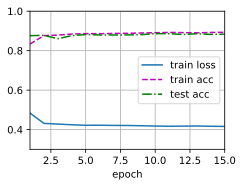

In [14]:
train(net=net,
      train_iter=train_iter,
      test_iter=test_iter,
      loss=loss,
      num_epochs=num_epochs,
      updater=optimizer)

## 4. 预测

预测一个批量的数据

In [15]:
def predict(net, test_iter):
    for X, y in test_iter:
        break
    return net(X).argmax(axis=1)

In [16]:
pred = predict(net=net, test_iter=test_iter)
len(pred)

256

In [17]:
pred

tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0])